# import

In [1]:
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr#

In [2]:
import pandas as pd
import numpy as np


from astropy.visualization import hist
from astroML.datasets import fetch_imaging_sample, fetch_sdss_S82standards
from astroML.crossmatch import crossmatch_angular


from datetime import datetime, date, timezone
from datetime import datetime
from datetime import timedelta
from astropy.time import Time
from astropy.io import ascii

import time
import os
from astropy import config as _config
from astroquery.irsa import Irsa   
from astropy import units as u
from astropy.coordinates import SkyCoord

from matplotlib.pyplot import MultipleLocator
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (AutoLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter
#import matplotlib.cm as cm
import matplotlib.colors as colors
from collections import OrderedDict



from astropy.io import fits 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import cm
from astropy.table import Table
import os
from collections import OrderedDict
from adjustText import adjust_text

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [4]:
from adjustText import adjust_text
import matplotlib as mpl
def set_ax_tick(ax):
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',)
    ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')

def set_ax_locator(ax,xma=1,xmi=0.2,yma=1,ymi=0.2):
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xma))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xmi))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yma))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ymi)) 

## convert mjd

In [5]:
def datetime2mjd(x):
    mjd_ref=59000
    mjd_minus_mdates_num=mdates.date2num(convert_xaxis_time(mjd_ref))-mjd_ref
    
    x=mdates.date2num(x)
    y = x - mjd_minus_mdates_num   
    return y

def mjd2datetime(x):
    mjd_ref=59000
    mjd_minus_mdates_num=mdates.date2num(convert_xaxis_time(mjd_ref))-mjd_ref
    y= x + mjd_minus_mdates_num
    y= mdates.num2date(y)
    return y



def datenums2mjd(x):
    #x=mdates.date2num(x)
    mjd_ref=59000
    mjd_minus_mdates_num=mdates.date2num(convert_xaxis_time(mjd_ref))-mjd_ref
    y = x - mjd_minus_mdates_num   
    return y

def mjd2numsdate(x):
    mjd_ref=59000
    mjd_minus_mdates_num=mdates.date2num(convert_xaxis_time(mjd_ref))-mjd_ref
    
    y= x + mjd_minus_mdates_num
    #y= mdates.num2date(y)
    return y

def convert_xaxis_mjd(time):
    return Time(time).mjd   

def convert_xaxis_time(mjd):
    return Time(mjd,format='mjd').to_datetime()


def date2yday(x):
    """
    x is in matplotlib datenums, so they are floats.
    """
    y = x - mdates.date2num(datetime(2018, 1, 1))
    return y

def yday2date(x):
    """
    return a matplotlib datenum (x is days since start of year of 2018)
    """
    y = x + mdates.date2num(datetime(2018, 1, 1))
    return y




def convert_partial_year(numbers):
    datetimes=[]
    for number in numbers:
        year = int(number)
        d = timedelta(days=(number - year)*(365 + is_leap(year)))
        day_one = datetime(year,1,1)
        date = d + day_one
        datetimes.append(date)
    return datetimes


def is_leap(year):
    if not year%4 and  year%100 or not year%400:
        return True
    return False


def convert_mjd(times):
    timesmjd=[]
    for i in times:
        timesmjd.append(Time(i).mjd)
    return timesmjd  


def convert_date(times):
    timesdate=[]
    for i in times:
        timesdate.append(Time(i,format='mjd').datetime)
    return timesdate

def convert_date_single(time):
    timedate=Time(time,format='mjd').datetime
    return timedate


In [6]:
mjd2datetime(57300)

datetime.datetime(2015, 10, 5, 0, 0, tzinfo=datetime.timezone.utc)

In [7]:
mjd2datetime(57300),mjd2datetime(58000),mjd2datetime(59000)
convert_xaxis_mjd(datetime(2015, 1, 1, 0, 0))

57023.0

## get_intrinsic_var

In [8]:
def get_intrinsic_var(data,mag_label,magerr_label,epsilon_s):
    mag_mean=np.average(data[mag_label])
    length_N=len(data[mag_label])
    epsilon_square=np.average(data[magerr_label]**2)+epsilon_s**2
    Sigma_square=np.sum((data[mag_label]-mag_mean)**2)/(length_N-1)
    
    if Sigma_square>epsilon_square:
        sigma_m=np.sqrt(Sigma_square-epsilon_square)
    else:
        sigma_m=0
        
    if length_N<2:
        sigma_m=-1#print(length_N)
    return sigma_m

## load_LLAGN

In [9]:
LLAGN=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/Source_lists/LLAGNtable.txt',delimiter='\t',header=0)
#CLAGN_list_2021_liu=CLAGN_list_2020[1:]
LLAGN.columns

Index(['Name', 'lg(L2-10keV)', 'Sigma_dis', 'lg(MBH/Msun)', 'lg(LEdd)',
       'lg(Lbol)', 'lg(Lbol/LEdd)', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')

In [10]:
len(LLAGN)

175

ls *.csv

## load_QSO

In [11]:
QSO=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/Source_lists/QSOtable.txt',delimiter='|',header=None)
QSO.columns=['Name', 'redshift', 'FWHM_Halpha', 'lg(LHalpha)', 'lg(L_Mbh)']#CLAGN_list_2021_liu=CLAGN_list_2020[1:]

In [ ]:
lg(LHalpha)=np.log10(5.25)+42+1.157*(L_5100A-44)

In [19]:
QSO['log(L5100)']=(QSO['lg(LHalpha)']-np.log10(5.25)-42)/1.157+44
QSO['log(Lbol)']=np.log10(9)+QSO['log(L5100)']
QSO['log(Ledd)']=np.log10(1.26*10**38)+QSO['lg(L_Mbh)']
QSO['log(Lbol/Ledd)']=QSO['log(Lbol)']-QSO['log(Ledd)']

In [20]:
QSO[:5]

,Name,redshift,FWHM_Halpha,lg(LHalpha),lg(L_Mbh),log(L5100),log(Lbol),log(Ledd),log(Lbol/Ledd)
0,J000000.47-002703.9,0.2500,2010,41.84,6.8,43.239275,44.193517,44.900371,-0.706853
1,J000048.15-095404.0,0.2060,2470,41.77,7.0,43.178773,44.133016,45.100371,-0.967355
2,J000102.19-102326.8,0.2940,5330,42.98,8.3,44.224581,45.178824,46.400371,-1.221547
3,J000111.15-100155.5,0.0489,1870,40.11,5.8,41.744028,42.698271,43.900371,-1.202100
4,J000154.28+000732.5,0.1390,2060,41.88,6.9,43.273847,44.228089,45.000371,-0.772281


In [21]:
len(QSO)*2

16994

In [13]:
max(QSO['redshift']),min(QSO['redshift'])

(0.35200000000000004, 0.0007)

## load_SDSS_DR7

In [14]:
SDSS_DR7_shen2011=Table.read('/Users/brettlv/blog/IHEP_sync/paper/high_variable_extreme_sources/J_ApJS_194_45/catalog.dat',
                      readme="/Users/brettlv/blog/IHEP_sync/paper/high_variable_extreme_sources/J_ApJS_194_45/ReadMe",
                      format="ascii.cds",)

In [15]:
len(SDSS_DR7_shen2011)

105783

In [16]:
SDSS_DR7_shen2011[28]

SDSS,RAdeg,DEdeg,z,Plate,Fiber,MJD,Flag,N,Uni,iMAG,logLbol,e_logLbol,BAL,FIRST,F6cm,logFnu,RL,logL5100,e_logL5100,logL3000,e_logL3000,logL1350,e_logL1350,logLBHa,e_logLBHa,W(BHa),e_W(BHa),EWBHa,e_EWBHa,logLNHa,e_logLNHa,W(NHa),e_W(NHa),EWNHa,e_EWNHa,logLNII,e_logLNII,EWNII,e_EWNII,logLSII1,e_logLSII1,EWSII1,e_EWSII1,logLSII3,e_logLSII3,EWSII3,e_EWSII3,EWFeHa,e_EWFeHa,alpHa,e_alpHa,NpHa,SN(Ha),chi2Ha,logLBHb,e_logLBHb,W(BHb),e_W(BHb),EWBHb,e_EWBHb,logLNHb,e_logLNHb,W(NHb),e_W(NHb),EWNHb,e_EWNHb,W(NHb)g,logLOIII4,e_logLOIII4,EWOIII4,e_EWOIII4,logLOIII5,e_logLOIII5,EWOIII5,e_EWOIII5,EWFeHb,e_EWFeHb,alpHb,e_alpHb,NpHb,SN(Hb),chi2Hb,logLMgII,e_logLMgII,W(MgII),e_W(MgII),EWMgII,e_EWMgII,logLBMgII,e_logLBMgII,W(BMgII),e_W(BMgII),EWBMgII,e_EWBMgII,W(BMgII)g,FeMgII,e_FeMgII,alphMgII,e_alphMgII,NpMgII,SN(MgII),chi2MgII,logLCIV,e_logLCIV,W(CIV),e_W(CIV),EWCIV,e_EWCIV,alpCIV,e_alpCIV,NpCIV,SN(CIV),chi2CIV,V(BHa),e_V(BHa),V(NHa),e_V(NHa),V(BHb),e_V(BHb),V(NHb),e_V(NHb),V(BMgII),e_V(BMgII),V(CIVp),e_V(CIVp),logBHHM,e_logBHHM,logBHHV,e_logBHHV,logBHMM,e_logBHMM,logBHMV,e_logBHMV,logBHMS,e_logBHMS,logBHCV,e_logBHCV,logBH,e_logBH,logEdd,SpF,zHW,e_zHW,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,umag0,gmag0,rmag0,imag0,zmag0,Delg-i,logNH,CR,oRASS,Jmag,Hmag,Ksmag,e_Jmag,e_Hmag,e_Ksmag,o2M,W1mag,W2mag,W3mag,W4mag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,oWISE
,deg,deg,,,,,,,,mag,[10-7W],[10-7W],,,mJy,[Jy],,[10-7W],[10-7W],[10-7W],[10-7W],[10-7W],[10-7W],[10-7W],[10-7W],km / s,km / s,0.1 nm,0.1 nm,[10-7W],[10-7W],km / s,km / s,0.1 nm,0.1 nm,[10-7W],[10-7W],0.1 nm,0.1 nm,[10-7W],[10-7W],0.1 nm,0.1 nm,[10-7W],[10-7W],0.1 nm,0.1 nm,0.1 nm,0.1 nm,,,,,,[10-7W],[10-7W],km / s,km / s,0.1 nm,0.1 nm,[10-7W],[10-7W],km / s,km / s,0.1 nm,0.1 nm,km / s,[10-7W],[10-7W],0.1 nm,0.1 nm,[10-7W],[10-7W],0.1 nm,0.1 nm,0.1 nm,0.1 nm,,,,,,[10-7W],[10-7W],km / s,km / s,0.1 nm,0.1 nm,[10-7W],[10-7W],km / s,km / s,0.1 nm,0.1 nm,km / s,0.1 nm,0.1 nm,,,,,,[10-7W],[10-7W],km / s,km / s,0.1 nm,0.1 nm,,,,,,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[Msun],[-],,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,[cm-2],ct / s,arcsec,mag,mag,mag,mag,mag,mag,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,arcsec
str18,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
000042.02-004501.3,0.1751,-0.75039,1.3115,685,196,52203,34603008,1,0,-24.83,45.807,0.012,0,0,0.0,-27.626,-1.0,0.0,-1.0,45.095,0.012,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-

In [75]:
SDSS_DR7_shen2011.colnames

['SDSS',
 'RAdeg',
 'DEdeg',
 'z',
 'Plate',
 'Fiber',
 'MJD',
 'Flag',
 'N',
 'Uni',
 'iMAG',
 'logLbol',
 'e_logLbol',
 'BAL',
 'FIRST',
 'F6cm',
 'logFnu',
 'RL',
 'logL5100',
 'e_logL5100',
 'logL3000',
 'e_logL3000',
 'logL1350',
 'e_logL1350',
 'logLBHa',
 'e_logLBHa',
 'W(BHa)',
 'e_W(BHa)',
 'EWBHa',
 'e_EWBHa',
 'logLNHa',
 'e_logLNHa',
 'W(NHa)',
 'e_W(NHa)',
 'EWNHa',
 'e_EWNHa',
 'logLNII',
 'e_logLNII',
 'EWNII',
 'e_EWNII',
 'logLSII1',
 'e_logLSII1',
 'EWSII1',
 'e_EWSII1',
 'logLSII3',
 'e_logLSII3',
 'EWSII3',
 'e_EWSII3',
 'EWFeHa',
 'e_EWFeHa',
 'alpHa',
 'e_alpHa',
 'NpHa',
 'SN(Ha)',
 'chi2Ha',
 'logLBHb',
 'e_logLBHb',
 'W(BHb)',
 'e_W(BHb)',
 'EWBHb',
 'e_EWBHb',
 'logLNHb',
 'e_logLNHb',
 'W(NHb)',
 'e_W(NHb)',
 'EWNHb',
 'e_EWNHb',
 'W(NHb)g',
 'logLOIII4',
 'e_logLOIII4',
 'EWOIII4',
 'e_EWOIII4',
 'logLOIII5',
 'e_logLOIII5',
 'EWOIII5',
 'e_EWOIII5',
 'EWFeHb',
 'e_EWFeHb',
 'alpHb',
 'e_alpHb',
 'NpHb',
 'SN(Hb)',
 'chi2Hb',
 'logLMgII',
 'e_logLMgII',
 'W(

In [17]:
SDSS_DR7_shen2011['SDSS'][28]

'000042.02-004501.3'

## load_extreme_qso

In [18]:
Extreme_QSO=pd.read_csv('/Users/brettlv/blog/IHEP_sync/paper/high_variable_extreme_sources/apjaaa9b6t2_mrt.txt',delimiter='\s+',header=None,skiprows=41)
Extreme_QSO.columns=['index', 'ra','dec','redshift', 'mjd_lo', 'gmag_lo','e_gmag_lo', 'mjd_hi','gmag_hi','e_gmag_hi','fFIRST']#CLAGN_list_2021_liu=CLAGN_list_2020[1:]

In [79]:
for index,name_index in enumerate(Extreme_QSO['index']):
    #print(i)
    name_sdss=SDSS_DR7_shen2011['SDSS'][name_index]
    search_name='SDSS'+name_sdss
    save_name='SDSS '+name_sdss
    Extreme_QSO.loc[index,'Name']=save_name
    Extreme_QSO.loc[index,'logLbol']=SDSS_DR7_shen2011['logLbol'][name_index]
    Extreme_QSO.loc[index,'e_logLbol']=SDSS_DR7_shen2011['e_logLbol'][name_index]
    Extreme_QSO.loc[index,'logBH']=SDSS_DR7_shen2011['logBH'][name_index]
    Extreme_QSO.loc[index,'logEdd']=SDSS_DR7_shen2011['logEdd'][name_index]
    
    
    

In [80]:
Extreme_QSO[:3]

,index,ra,dec,redshift,mjd_lo,gmag_lo,e_gmag_lo,mjd_hi,gmag_hi,e_gmag_hi,...,len_neo,pearson_coeff_neo,sigma_m_w1_neo,mean_m_w1_neo,sigma_m_w2_neo,mean_m_w2_neo,logLbol,e_logLbol,logBH,logEdd
0,28,0.175101,-0.750386,1.3115,52931.22,20.900,0.040,51081.00,19.857,0.023,...,0.0,NaN,NaN,NaN,NaN,NaN,45.807,0.012,9.22,-1.51
1,33,0.192320,-0.501993,1.4453,54373.38,20.636,0.100,51075.30,19.459,0.022,...,0.0,NaN,NaN,NaN,NaN,NaN,46.136,0.009,9.02,-0.99
2,50,0.268872,0.464944,0.5512,56546.27,21.238,0.017,51819.36,20.189,0.026,...,0.0,NaN,NaN,NaN,NaN,NaN,45.054,0.008,8.39,-1.44


In [21]:
!ls ../EVQ/*.csv | wc -l

     977


### download_EVQ

In [22]:
#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120
for index,name_index in enumerate(Extreme_QSO['index']):
    #print(i)
    name_sdss=SDSS_DR7_shen2011['SDSS'][name_index]
    search_name='SDSS'+name_sdss
    save_name='SDSS '+name_sdss
   

    if not os.path.exists('../EVQ/mep/wise_%s_mep.csv'%save_name):
        print(index,search_name,'mep')
        try:
            Irsa.ROW_LIMIT = 1000
            Irsa.TIMEOUT = 120
            table_wise_mep=Irsa.query_region(search_name,catalog='allwise_p3as_mep',spatial='Cone',radius=10*u.arcsec,)
            table_wise_mep.write('../EVQ/mep/wise_%s_mep.csv'%save_name, format='csv')
            time.sleep(10+np.random.randint(5,10))
        except Exception:
            continue
            #raise            
    
    if not os.path.exists('../EVQ/wise_%s_neo.csv'%save_name):
        print(index,search_name,'neo')
        try:
            Irsa.ROW_LIMIT = 1000
            Irsa.TIMEOUT = 120

            table_wise_neo=Irsa.query_region(search_name,catalog='neowiser_p1bs_psd',spatial='Cone',radius=10*u.arcsec,)  
            table_wise_neo.write('../EVQ/wise_%s_neo.csv'%save_name, format='csv')       
            time.sleep(10+np.random.randint(5,10))   
        except Exception:
            continue
            #raise                

822 SDSS230751.90-003016.3 mep
WARNING: NoResultsWarning: The IRSA server sent back an empty reply [astroquery.irsa.core]
wise_SDSS 230751.90-003016.3_mep.csv

In [23]:
min(Extreme_QSO['redshift']),max(Extreme_QSO['redshift'])

(0.1739, 4.3028)

(array([152., 158., 281., 236., 103.,  28.,   7.,   6.,   2.,   4.]),
 array([0.1739 , 0.58679, 0.99968, 1.41257, 1.82546, 2.23835, 2.65124,
        3.06413, 3.47702, 3.88991, 4.3028 ]),
 <BarContainer object of 10 artists>)

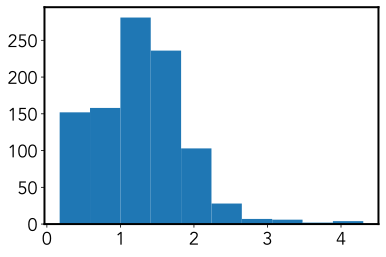

In [24]:
plt.hist(Extreme_QSO['redshift'])

## EVG_neo_var

In [72]:
epsilon_s_w1=0.024
epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_neo']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_neo']=-1
for index,name_index in enumerate(Extreme_QSO['index']):
    #print(i)
    name_sdss=SDSS_DR7_shen2011['SDSS'][name_index]
    search_name='SDSS'+name_sdss
    save_name='SDSS '+name_sdss
    print(index,name_index,save_name)
    
    data=pd.read_csv('../EVQ/wise_%s_neo.csv'%save_name)
    data=data[data['w1mpro'].notnull()]
    data=data[data['w2mpro'].notnull()]
    data=data[data['w1sigmpro'].notnull()]
    data=data[data['w2sigmpro'].notnull()]
    
    data=data[data['w1mpro']<15]
    data=data[data['w2mpro']<13] 
    
    #data=data[data['w1rchi2']<2]    
    data=data[data['qual_frame']>0]    
    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    if len(data)>2:
        mag_label='w1mpro'
        magerr_label='w1sigmpro'
        epsilon_s=epsilon_s_w1
        
        pearson_coeff,p_value=pearsonr(data['w1mpro'],data['w2mpro'])
        Extreme_QSO.loc[index,'pearson_coeff_neo']=pearson_coeff
        
        sigma_m_w1=get_intrinsic_var(data,mag_label,magerr_label,epsilon_s)
        Extreme_QSO.loc[index,'sigma_m_w1_neo']=sigma_m_w1
        Extreme_QSO.loc[index,'mean_m_w1_neo']=np.average(data[mag_label])
        

        mag_label='w2mpro'
        magerr_label='w2sigmpro'
        epsilon_s=epsilon_s_w2
        sigma_m_w2=get_intrinsic_var(data,mag_label,magerr_label,epsilon_s)
        Extreme_QSO.loc[index,'sigma_m_w2_neo']=sigma_m_w2
        Extreme_QSO.loc[index,'mean_m_w2_neo']=np.average(data[mag_label])
        
        Extreme_QSO.loc[index,'len_neo']=len(data)
        
    else:
        Extreme_QSO.loc[index,'len_neo']=0
        #print(index,i)

0 28 SDSS 000042.02-004501.3
1 33 SDSS 000046.15-003007.1
2 50 SDSS 000104.52+002753.7
3 90 SDSS 000209.05+000552.8
4 97 SDSS 000219.11+002232.9
5 124 SDSS 000303.32+001019.6
6 147 SDSS 000347.20+005344.7
7 170 SDSS 000429.47-002142.8
8 178 SDSS 000439.97-000146.4
9 203 SDSS 000508.37+010806.4
10 214 SDSS 000527.52-000556.2
11 217 SDSS 000530.66+010233.3
12 260 SDSS 000645.41+000613.9
13 277 SDSS 000710.01+005329.1
14 291 SDSS 000739.54-000519.8
15 304 SDSS 000754.99-010206.7
16 347 SDSS 000901.01-000306.7
17 361 SDSS 000917.68-001344.8
18 372 SDSS 000943.37+010459.8
19 377 SDSS 000952.42+010717.7
20 383 SDSS 001002.84+010407.5
21 385 SDSS 001004.96-004906.8
22 394 SDSS 001016.22+004713.3
23 427 SDSS 001055.41+003032.2
24 432 SDSS 001100.87-001532.1
25 435 SDSS 001105.57+002653.5
26 443 SDSS 001114.22+010928.7
27 450 SDSS 001130.40+005751.7
28 457 SDSS 001135.06-011421.9
29 468 SDSS 001152.78+010005.2
30 480 SDSS 001212.67-000109.7
31 493 SDSS 001233.34+010010.3
32 504 SDSS 001252.64-0

270 4271 SDSS 014048.62-003500.9
271 4292 SDSS 014110.40+003107.1
272 4294 SDSS 014115.07-003041.5
273 4298 SDSS 014124.25+010306.4
274 4306 SDSS 014134.19-004648.5
275 4310 SDSS 014136.23+002508.5
276 4311 SDSS 014136.40-001019.7
277 4312 SDSS 014136.51-083847.3
278 4317 SDSS 014146.02+005709.3
279 4320 SDSS 014150.61+000754.2
280 4325 SDSS 014158.14-000751.1
281 4334 SDSS 014210.80-005901.5
282 4335 SDSS 014212.86-002453.4
283 4383 SDSS 014309.22-005330.8
284 4410 SDSS 014400.04-001210.6
285 4411 SDSS 014401.21+002256.6
286 4416 SDSS 014410.59+003848.1
287 4437 SDSS 014435.54+000131.5
288 4473 SDSS 014531.56+002459.4
289 4479 SDSS 014542.77+005314.9
290 4488 SDSS 014555.58-010531.5
291 4520 SDSS 014645.58-001829.9
292 4544 SDSS 014731.97-002019.4
293 4551 SDSS 014744.04-000233.3
294 4555 SDSS 014756.98-011335.3
295 4567 SDSS 014816.73-004822.8
296 4581 SDSS 014840.10+001224.3
297 4584 SDSS 014850.03+003013.6
298 4593 SDSS 014905.28-011404.9
299 4596 SDSS 014908.91+005655.3
300 4609 S

519 6623 SDSS 023636.17-003317.8
520 6626 SDSS 023644.42-011452.8
521 6644 SDSS 023710.11-005031.6
522 6667 SDSS 023742.68-000747.9
523 6670 SDSS 023748.51+011037.9
524 6687 SDSS 023814.15+001941.4
525 6688 SDSS 023815.92-002012.2
526 6702 SDSS 023838.94+004324.9
527 6709 SDSS 023900.58+002041.9
528 6720 SDSS 023916.85+005153.8
529 6724 SDSS 023921.18+010628.0
530 6734 SDSS 023927.06+010029.2
531 6787 SDSS 024046.85-001324.9
532 6788 SDSS 024047.91+004440.0
533 6794 SDSS 024053.32+001108.8
534 6796 SDSS 024055.81-081953.3
535 6797 SDSS 024056.49+002912.3
536 6803 SDSS 024105.05-005132.6
537 6863 SDSS 024235.43+004605.1
538 6868 SDSS 024240.96+002150.8
539 6871 SDSS 024242.41+004015.4
540 6876 SDSS 024251.01+001010.9
541 6877 SDSS 024254.66-072205.6
542 6882 SDSS 024300.45-003030.2
543 6886 SDSS 024306.67-002531.4
544 6887 SDSS 024306.83+001219.4
545 6900 SDSS 024328.86+003831.2
546 6910 SDSS 024340.98-002601.2
547 6933 SDSS 024424.63-001219.8
548 6954 SDSS 024453.25-011256.4
549 6956 S

774 103158 SDSS 224302.18+001756.9
775 103159 SDSS 224304.09-010946.4
776 103170 SDSS 224331.92-001232.9
777 103180 SDSS 224348.31+003437.8
778 103202 SDSS 224433.56+000735.4
779 103230 SDSS 224532.52+005857.9
780 103242 SDSS 224550.96+005135.4
781 103288 SDSS 224721.08-000812.0
782 103339 SDSS 224900.14-010414.5
783 103345 SDSS 224922.94-010745.8
784 103347 SDSS 224924.01+004750.4
785 103390 SDSS 225050.10-010406.7
786 103393 SDSS 225053.29-002335.8
787 103424 SDSS 225213.19-002304.2
788 103433 SDSS 225223.39+010757.1
789 103439 SDSS 225240.37+010958.7
790 103446 SDSS 225250.73+000418.3
791 103448 SDSS 225252.44-000532.5
792 103466 SDSS 225339.09-002447.4
793 103482 SDSS 225417.74-003200.7
794 103520 SDSS 225534.10-000017.1
795 103540 SDSS 225622.81-001809.9
796 103564 SDSS 225711.58+002819.3
797 103583 SDSS 225757.22-002608.3
798 103594 SDSS 225816.28-002602.8
799 103598 SDSS 225820.99+001605.3
800 103626 SDSS 225918.16-000112.0
801 103643 SDSS 225947.34+003032.9
802 103646 SDSS 2259

In [73]:
len(Extreme_QSO[Extreme_QSO['len_neo']>0])

49

In [74]:
Extreme_QSO[Extreme_QSO['len_neo']==0]

,index,ra,dec,redshift,mjd_lo,gmag_lo,e_gmag_lo,mjd_hi,gmag_hi,e_gmag_hi,fFIRST,Name,len_neo,pearson_coeff_neo,sigma_m_w1_neo,mean_m_w1_neo,sigma_m_w2_neo,mean_m_w2_neo
0,28,0.175101,-0.750386,1.3115,52931.22,20.900,0.040,51081.00,19.857,0.023,0,SDSS 000042.02-004501.3,0.0,NaN,NaN,NaN,NaN,NaN
1,33,0.192320,-0.501993,1.4453,54373.38,20.636,0.100,51075.30,19.459,0.022,0,SDSS 000046.15-003007.1,0.0,NaN,NaN,NaN,NaN,NaN
2,50,0.268872,0.464944,0.5512,56546.27,21.238,0.017,51819.36,20.189,0.026,0,SDSS 000104.52+002753.7,0.0,NaN,NaN,NaN,NaN,NaN
3,90,0.537709,0.098022,2.1447,54387.33,21.367,0.054,51819.36,20.204,0.027,0,SDSS 000209.05+000552.8,0.0,NaN,NaN,NaN,NaN,NaN
4,97,0.579628,0.375815,0.5467,53314.21,20.722,0.036,52253.19,19.699,0.035,0,SDSS 000219.11+002232.9,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,105735,359.710846,0.054231,2.0050,51819.36,21.074,0.040,53975.30,20.030,0.029,0,SDSS 235850.60+000315.2,0.0,NaN,NaN,NaN,NaN,NaN
973,105749,359.788269,0.961563,1.1687,53705.21,21.783,0.084,51819.36,20.510,0.032,0,SDSS 235909.18+005741.6,0.0,NaN,NaN,NaN,NaN,NaN
974,105756,359.829803,-0.522517,0.8365,53312.20,21.575,0.103,51075.30,20.152,0.026,0,SDSS 235919.15-003121.0,0.0,NaN,NaN,NaN,NaN,NaN
975,105766,359.903412,-0.520211,1.0956,56932.24,22.386,0.048,52231.20,20.208,0.038,1,SDSS 235936.81-003112.7,0.0,NaN,NaN,NaN,NaN,NaN


In [81]:
Extreme_QSO.to_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/Extreme_QSO.csv',index=False)

## download_LLAGN

In [32]:
#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120
for index,i in enumerate(LLAGN['Name'][:]):
    #print(i)
    search_name=i.replace(' ','') 
    save_name=i
    if not os.path.exists('wise_%s_mep.csv'%save_name):
        print(index,search_name)
        Irsa.ROW_LIMIT = 1000
        Irsa.TIMEOUT = 120
        table_wise_mep=Irsa.query_region(search_name,catalog='allwise_p3as_mep',spatial='Cone',radius=10*u.arcsec,)
        table_wise_mep.write('wise_%s_mep.csv'%save_name, format='csv')
        time.sleep(15+np.random.randint(5,10))    
    
    if not os.path.exists('wise_%s_neo.csv'%save_name):
        Irsa.ROW_LIMIT = 1000
        Irsa.TIMEOUT = 120
        
        table_wise_neo=Irsa.query_region(search_name,catalog='neowiser_p1bs_psd',spatial='Cone',radius=10*u.arcsec,)  
        table_wise_neo.write('wise_%s_neo.csv'%save_name, format='csv')       
        time.sleep(15+np.random.randint(5,10))      


## check_down_LLAGN

In [33]:
#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120

for index,i in enumerate(LLAGN['Name']):    
    search_name=i.replace(' ','')
    if  not os.path.exists('wise_%s_mep.csv'%i):
        print(index,i)
        print('***mep notdone')
        
      
    if  not os.path.exists('wise_%s_neo.csv'%i):
        print(index,i)
        print('***neo notdone')        
        

## LLAGN_data_test

In [ ]:
data_test_mep_origin=pd.read_csv('wise_%s_mep.csv'%LLAGN['Name'][0])
data_test_mep_origin.columns

data_test_mep_origin['moon_masked']

In [ ]:
data_test_neo_origin=pd.read_csv('wise_%s_neo.csv'%LLAGN['Name'][21])
data_test_neo_origin.columns

### NGC 1068

In [ ]:
test_index=21
print(LLAGN['Name'][test_index])
data_test_neo=pd.read_csv('wise_%s_neo.csv'%LLAGN['Name'][test_index])
data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
print(len(data_test_neo))
data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                             'w1sigmpro','w2sigmpro',
                             ]].sort_values('mjd'))
data_test_neo=data_test_neo.reset_index(drop=True)
data_test_neo.columns

In [ ]:
epsilon_s_w1=0.024
epsilon_s_w2=0.028

mag_label='w1mpro'
magerr_label='w1sigmpro'
epsilon_s=epsilon_s_w1
sigma_m_w1=get_intrinsic_var(data_test_neo[data_test_neo['mjd']>57023],mag_label,magerr_label,epsilon_s)
print(sigma_m_w1)

mag_label='w1mpro'
magerr_label='w1sigmpro'
epsilon_s=epsilon_s_w1
sigma_m_w1=get_intrinsic_var(data_test_neo[data_test_neo['mjd']<57023],mag_label,magerr_label,epsilon_s)
print(sigma_m_w1)

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red')

plt.xlabel('mjd')
plt.ylabel(r'$W1$')
#plt.ylim(18,0)
ax.text(0.15, 0.9,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

In [ ]:
mag_label='w2mpro'
magerr_label='w2sigmpro'
epsilon_s=epsilon_s_w1

ref_time_mjd=59023
print(len(data_test_neo[data_test_neo['mjd']>ref_time_mjd]))
sigma_m_w2=get_intrinsic_var(data_test_neo[data_test_neo['mjd']>ref_time_mjd],mag_label,magerr_label,epsilon_s)
print(mjd2datetime(ref_time_mjd))
print(sigma_m_w2)

In [ ]:
mag_label='w2mpro'
magerr_label='w2sigmpro'
epsilon_s=epsilon_s_w1

ref_time_mjd=58023
print(len(data_test_neo[data_test_neo['mjd']>ref_time_mjd]))
sigma_m_w2=get_intrinsic_var(data_test_neo[data_test_neo['mjd']>ref_time_mjd],mag_label,magerr_label,epsilon_s)
print(mjd2datetime(ref_time_mjd))
print(sigma_m_w2)

In [ ]:
epsilon_s_w1=0.024
epsilon_s_w2=0.028

mag_label='w2mpro'
magerr_label='w2sigmpro'
epsilon_s=epsilon_s_w1
sigma_m_w2=get_intrinsic_var(data_test_neo[data_test_neo['mjd']>57023],mag_label,magerr_label,epsilon_s)
print(mjd2datetime(57023))
print(sigma_m_w2)

mag_label='w2mpro'
magerr_label='w2sigmpro'
epsilon_s=epsilon_s_w1
sigma_m_w2=get_intrinsic_var(data_test_neo[data_test_neo['mjd']<57023],mag_label,magerr_label,epsilon_s)
print(sigma_m_w2)

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='red')

plt.xlabel('mjd')
plt.ylabel(r'$W2$')
#plt.ylim(18,0)
ax.text(0.15, 0.8,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['w1mpro'],data_test_neo['w2mpro'],color='red')

plt.xlabel('W1')
plt.ylabel(r'$W2$')
#set_ax_locator(ax)
set_ax_tick(ax)
#plt.xlim(18,0)
ax.text(0.15, 0.8,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

## LLAGN_neo_var

In [34]:
LLAGN.columns

Index(['Name', 'lg(L2-10keV)', 'Sigma_dis', 'lg(MBH/Msun)', 'lg(LEdd)',
       'lg(Lbol)', 'lg(Lbol/LEdd)', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')

In [57]:
epsilon_s_w1=0.024
epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_neo']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_neo']=-1
for index,i in enumerate(LLAGN['Name']):
    save_name=i
    data=pd.read_csv('wise_%s_neo.csv'%save_name)
    data=data[data['w1mpro'].notnull()]
    data=data[data['w2mpro'].notnull()]
    data=data[data['w1sigmpro'].notnull()]
    data=data[data['w2sigmpro'].notnull()]
    
    data=data[data['w1mpro']<15]
    data=data[data['w2mpro']<13]    
    #data=data[data['w1rchi2']<2]    
    data=data[data['qual_frame']>0]    
    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    if len(data)>2:
        mag_label='w1mpro'
        magerr_label='w1sigmpro'
        epsilon_s=epsilon_s_w1
        
        pearson_coeff,p_value=pearsonr(data['w1mpro'],data['w2mpro'])
        LLAGN.loc[index,'pearson_coeff_neo']=pearson_coeff
        
        sigma_m_w1=get_intrinsic_var(data,mag_label,magerr_label,epsilon_s)
        LLAGN.loc[index,'sigma_m_w1_neo']=sigma_m_w1
        LLAGN.loc[index,'mean_m_w1_neo']=np.average(data[mag_label])
        

        mag_label='w2mpro'
        magerr_label='w2sigmpro'
        epsilon_s=epsilon_s_w2
        sigma_m_w2=get_intrinsic_var(data,mag_label,magerr_label,epsilon_s)
        LLAGN.loc[index,'sigma_m_w2_neo']=sigma_m_w2
        LLAGN.loc[index,'mean_m_w2_neo']=np.average(data[mag_label])
        
        LLAGN.loc[index,'len_neo']=len(data)
        
    else:
        LLAGN.loc[index,'len_neo']=0
        #print(index,i)

In [58]:
len(LLAGN[LLAGN['len_neo']>0])

173

In [59]:
LLAGN.columns

Index(['Name', 'lg(L2-10keV)', 'Sigma_dis', 'lg(MBH/Msun)', 'lg(LEdd)',
       'lg(Lbol)', 'lg(Lbol/LEdd)', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'len_neo', 'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo'],
      dtype='object')

LLAGN=LLAGN.drop('Unnamed: 7',1)

In [60]:
LLAGN.to_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/LLAGN.csv',index=False)

## high_variable

In [38]:
LLAGN[LLAGN['sigma_m_w1_neo']>0.5]

,Name,lg(L2-10keV),Sigma_dis,lg(MBH/Msun),lg(LEdd),lg(Lbol),lg(Lbol/LEdd),Unnamed: 7,Unnamed: 8,Unnamed: 9,len_neo,pearson_coeff_neo,sigma_m_w1_neo,mean_m_w1_neo,sigma_m_w2_neo,mean_m_w2_neo


In [39]:
LLAGN[LLAGN['sigma_m_w1_neo']>0.4]

,Name,lg(L2-10keV),Sigma_dis,lg(MBH/Msun),lg(LEdd),lg(Lbol),lg(Lbol/LEdd),Unnamed: 7,Unnamed: 8,Unnamed: 9,len_neo,pearson_coeff_neo,sigma_m_w1_neo,mean_m_w1_neo,sigma_m_w2_neo,mean_m_w2_neo


In [40]:
LLAGN[LLAGN['sigma_m_w2_neo']>0.5]

,Name,lg(L2-10keV),Sigma_dis,lg(MBH/Msun),lg(LEdd),lg(Lbol),lg(Lbol/LEdd),Unnamed: 7,Unnamed: 8,Unnamed: 9,len_neo,pearson_coeff_neo,sigma_m_w1_neo,mean_m_w1_neo,sigma_m_w2_neo,mean_m_w2_neo


In [41]:
LLAGN[LLAGN['sigma_m_w2_neo']>0.4]

,Name,lg(L2-10keV),Sigma_dis,lg(MBH/Msun),lg(LEdd),lg(Lbol),lg(Lbol/LEdd),Unnamed: 7,Unnamed: 8,Unnamed: 9,len_neo,pearson_coeff_neo,sigma_m_w1_neo,mean_m_w1_neo,sigma_m_w2_neo,mean_m_w2_neo
21,NGC 1068,43.63,161.8,7.759953,45.873896,44.828657,-1.045239,NaN,NaN,NaN,39.0,0.37818,0.265812,3.602949,0.460375,1.774385


### NGC 221

In [ ]:
test_index=5
print(LLAGN['Name'][test_index])
data_test_neo=pd.read_csv('wise_%s_neo.csv'%LLAGN['Name'][test_index])
data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
print(len(data_test_neo))
data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                             'w1sigmpro','w2sigmpro',
                             ]].sort_values('mjd'))
data_test_neo=data_test_neo.reset_index(drop=True)
data_test_neo.columns


epsilon_s_w1=0.024
epsilon_s_w2=0.028

mag_label='w1mpro'
magerr_label='w1sigmpro'
epsilon_s=epsilon_s_w1
sigma_m_w1=get_intrinsic_var(data_test_neo,mag_label,magerr_label,epsilon_s)
print(sigma_m_w1)

epsilon_s_w1=0.024
epsilon_s_w2=0.028

mag_label='w2mpro'
magerr_label='w2sigmpro'
epsilon_s=epsilon_s_w1
sigma_m_w2=get_intrinsic_var(data_test_neo,mag_label,magerr_label,epsilon_s)
print(sigma_m_w2)

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red')

plt.xlabel('mjd')
plt.ylabel(r'$W1$')
#plt.ylim(18,0)
ax.text(0.15, 0.9,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='red')

plt.xlabel('mjd')
plt.ylabel(r'$W2$')
#plt.ylim(18,0)
ax.text(0.15, 0.2,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['w1mpro'],data_test_neo['w2mpro'],color='red')

plt.xlabel('W1')
plt.ylabel(r'$W2$')
#set_ax_locator(ax)
set_ax_tick(ax)
#plt.xlim(18,0)
ax.text(0.15, 0.8,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

### NGC 224

In [ ]:
test_index=6
print(LLAGN['Name'][test_index])
data_test_neo=pd.read_csv('wise_%s_neo.csv'%LLAGN['Name'][test_index])
data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
print(len(data_test_neo))
data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                             'w1sigmpro','w2sigmpro',
                             ]].sort_values('mjd'))
data_test_neo=data_test_neo.reset_index(drop=True)
data_test_neo.columns


epsilon_s_w1=0.024
epsilon_s_w2=0.028

mag_label='w1mpro'
magerr_label='w1sigmpro'
epsilon_s=epsilon_s_w1
sigma_m_w1=get_intrinsic_var(data_test_neo,mag_label,magerr_label,epsilon_s)
print(sigma_m_w1)

epsilon_s_w1=0.024
epsilon_s_w2=0.028

mag_label='w2mpro'
magerr_label='w2sigmpro'
epsilon_s=epsilon_s_w1
sigma_m_w2=get_intrinsic_var(data_test_neo,mag_label,magerr_label,epsilon_s)
print(sigma_m_w2)

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red')

plt.xlabel('mjd')
plt.ylabel(r'$W1$')
#plt.ylim(18,0)
ax.text(0.15, 0.9,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='red')

plt.xlabel('mjd')
plt.ylabel(r'$W2$')
#plt.ylim(18,0)
ax.text(0.15, 0.8,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

In [ ]:
data_test_neo.columns

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(data_test_neo['w1mpro'],data_test_neo['w2mpro'],color='red')

plt.xlabel('W1')
plt.ylabel(r'$W2$')
#set_ax_locator(ax)
set_ax_tick(ax)
#plt.xlim(18,0)
ax.text(0.15, 0.8,LLAGN['Name'][test_index] , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

## sigma_w1 sigma_w2

In [45]:
LLAGN[LLAGN['sigma_m_w1_neo']-LLAGN['sigma_m_w2_neo']>0.01]

,Name,lg(L2-10keV),Sigma_dis,lg(MBH/Msun),lg(LEdd),lg(Lbol),lg(Lbol/LEdd),Unnamed: 7,Unnamed: 8,Unnamed: 9,len_neo,pearson_coeff_neo,sigma_m_w1_neo,mean_m_w1_neo,sigma_m_w2_neo,mean_m_w2_neo


Text(0, 0.5, '$\\sigma_m w2$')

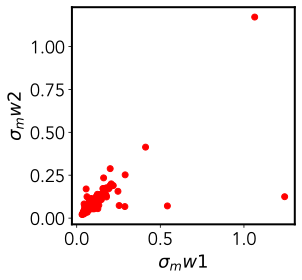

In [64]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(LLAGN['sigma_m_w1_neo'],LLAGN['sigma_m_w2_neo'],color='red')

plt.xlabel(r'$\sigma_m w1$')
plt.ylabel(r'$\sigma_m w2$')

#plt.semilogy()

## sigma_w1 W1

(13.502386602870816, 3.564933971291865)

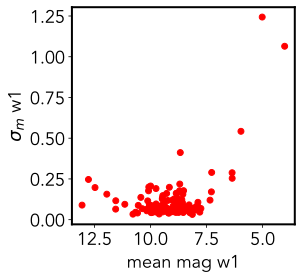

In [69]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(LLAGN['mean_m_w1_neo'],LLAGN['sigma_m_w1_neo'],color='red')

plt.xlabel('mean mag w1')
plt.ylabel(r'$\sigma_m$ w1')
#plt.xlim(18,0)
bottom, top = plt.xlim() 
plt.xlim(top,bottom)

#ax.text(0.1, 0.9, 'w1_neo', horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

## sigma_w2 w2

(13.430093006379586, 1.5289416028708134)

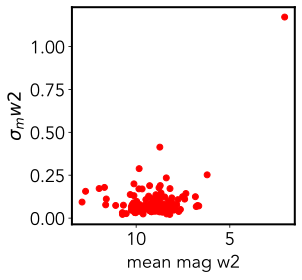

In [70]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(LLAGN['mean_m_w2_neo'],LLAGN['sigma_m_w2_neo'],color='red')

plt.xlabel('mean mag w2')
plt.ylabel(r'$\sigma_m w2$')
bottom, top = plt.xlim() 
plt.xlim(top,bottom)
#ax.text(0.1, 0.9, 'w2_neo', horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

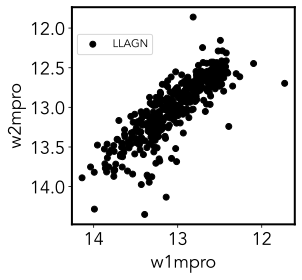

In [71]:
#epsilon_s_w1=0.024
#epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_neo']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_neo']=-1

fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

for index,i in enumerate(LLAGN['Name'][:1]):

    color='black'
    label='LLAGN'
    marker='o'
       
    data=pd.read_csv('wise_%s_neo.csv'%i)
    data=data[data['w1mpro'].notnull()]
    data=data[data['w2mpro'].notnull()]
    data=data[data['w1sigmpro'].notnull()]
    data=data[data['w2sigmpro'].notnull()]
    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    x_label='w1mpro'
    xerr_label='w1sigmpro'
    y_label='w2mpro'
    yerr_label='w2sigmpro'   
    
    for d in range(len(data)):
        plt.scatter(data.iloc[d][x_label],data.iloc[d][y_label],
                color=color,marker=marker,
                label=label)

plt.xlabel(x_label)
plt.ylabel(y_label)
bottom, top = plt.xlim() 
plt.xlim(top,bottom)

bottom, top = plt.ylim() 
plt.ylim(top,bottom)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

## download_QSO

In [ ]:
pwd

#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120

for index,name in enumerate(QSO['Name'][:2000]):
    #print(i)
    search_name='SDSS'+name.replace(' ','') 
    save_name='SDSS '+name.replace(' ','') 
   
    if not os.path.exists('../QSO/wise_%s_mep.csv'%save_name):
        print(index,search_name)
        try:
            Irsa.ROW_LIMIT = 1000
            Irsa.TIMEOUT = 120
            table_wise_mep=Irsa.query_region(search_name,catalog='allwise_p3as_mep',spatial='Cone',radius=10*u.arcsec,)
            table_wise_mep.write('../QSO/wise_%s_mep.csv'%save_name, format='csv')
            time.sleep(10+np.random.randint(5,10))
        except Exception:
            continue
            #raise             
    
    if not os.path.exists('../QSO/wise_%s_neo.csv'%save_name):
        try:
            Irsa.ROW_LIMIT = 1000
            Irsa.TIMEOUT = 120

            table_wise_neo=Irsa.query_region(search_name,catalog='neowiser_p1bs_psd',spatial='Cone',radius=10*u.arcsec,)  
            table_wise_neo.write('../QSO/wise_%s_neo.csv'%save_name, format='csv')       
            time.sleep(10+np.random.randint(5,10))   
        except Exception:
            continue
            #raise                

In [ ]:
pwd

## check_down_qso

In [ ]:
for index,name in enumerate(QSO['Name'][:2000]):
    #print(i)
    search_name='SDSS'+name.replace(' ','') 
    i='SDSS '+name.replace(' ','')     
    if not os.path.exists('../QSO/wise_%s_mep.csv'%i):
        print(index,search_name,'mep')
    
    if not os.path.exists('../QSO/wise_%s_neo.csv'%i):
        print(index,search_name,'neo')

# BAT_105m_catalog_07jul2019

In [ ]:
BAT_105m_catalog_07jul2019=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/Source_lists/BAT_105m_catalog_07jul2019.txt',
                                       delimiter="|",header=0,skiprows=1)

BAT_105m_catalog_07jul2019=BAT_105m_catalog_07jul2019[BAT_105m_catalog_07jul2019['                 TYPE'].notnull()]

In [ ]:
BAT_105m_Seyfert=BAT_105m_catalog_07jul2019[BAT_105m_catalog_07jul2019['                 TYPE'].str.contains('Sy')]
BAT_105m_Seyfert=BAT_105m_Seyfert.reset_index(drop=True)

BAT_105m_Seyfert

# QPE

In [100]:
qpe_name_list=['GSN069','RXJ1301.9+2747','2MASS02314715-1020112','2MASXJ02344872-4419325']

In [101]:
#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120

for index,name in enumerate(qpe_name_list):
    #print(i)
    search_name=name.replace(' ','')
    save_name=name
   
    if not os.path.exists('../QPE/wise_%s_mep.csv'%save_name):
        print(index,search_name)
        try:
            Irsa.ROW_LIMIT = 1000
            Irsa.TIMEOUT = 120
            table_wise_mep=Irsa.query_region(search_name,catalog='allwise_p3as_mep',spatial='Cone',radius=10*u.arcsec,)
            table_wise_mep.write('../QPE/wise_%s_mep.csv'%save_name, format='csv')
            time.sleep(10+np.random.randint(5,10))
        except Exception:
            continue
            #raise             
    
    if not os.path.exists('../QPE/wise_%s_neo.csv'%save_name):
        try:
            Irsa.ROW_LIMIT = 1000
            Irsa.TIMEOUT = 120

            table_wise_neo=Irsa.query_region(search_name,catalog='neowiser_p1bs_psd',spatial='Cone',radius=10*u.arcsec,)  
            table_wise_neo.write('../QPE/wise_%s_neo.csv'%save_name, format='csv')       
            time.sleep(10+np.random.randint(5,10))   
        except Exception:
            continue
            #raise                

## lightcurve

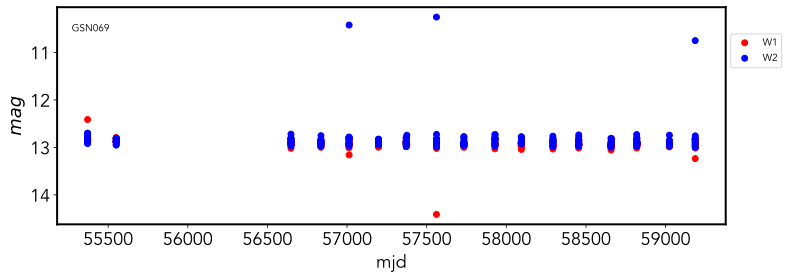

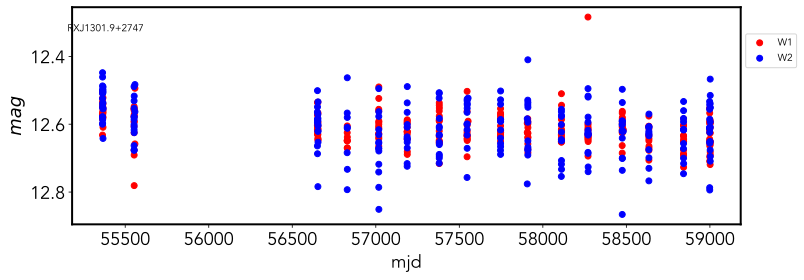

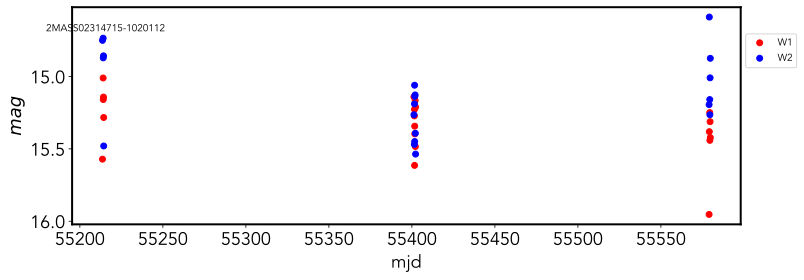

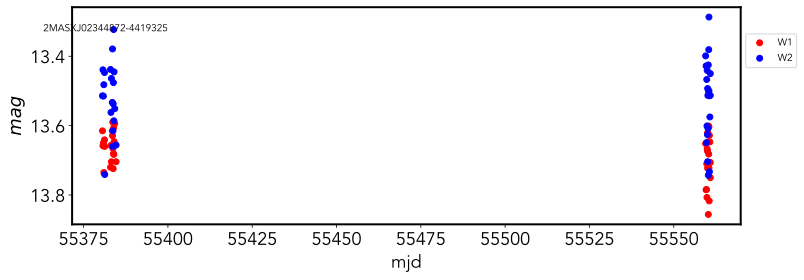

In [102]:
plotlist=qpe_name_list

for index_test in range(len(qpe_name_list)):
    name_test=plotlist[index_test]
    #print(name_test)
    search_name=name_test
    #search_name=name_test.replace(' ','') 
    save_name=search_name

    data_test_neo=pd.read_csv('../QPE/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13] 
    #data_test_neo=data_test_neo[data_test_neo['w1snr']>10]
    #data_test_neo=data_test_neo[data_test_neo['w2snr']>10]
    
    #data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>0]
    
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('../QPE/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    
    fig = plt.figure(figsize=(12,4))
    fig.subplots_adjust(hspace=0.0, wspace = 0.0)
    ax = fig.add_subplot(111)

    ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')

    
    ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
          loc=2,fontsize=10)
    
    bottom, top = plt.ylim() 
    plt.ylim(top,bottom)
    
    plt.xlabel('mjd')
    plt.ylabel(r'$mag$')
    
    ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
    plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/QPElc/WISE_lc_%s.png'%save_name, 
            dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    

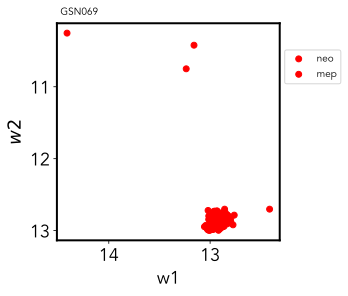

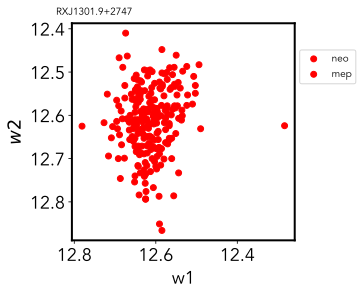

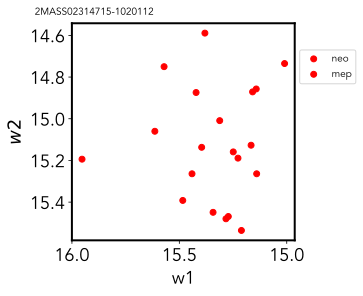

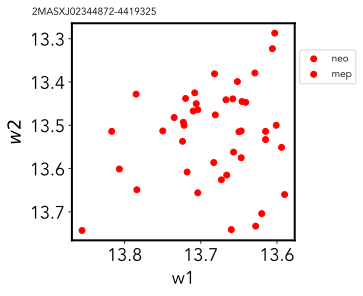

In [107]:
plotlist=qpe_name_list

for index_test in range(len(qpe_name_list)):
    name_test=plotlist[index_test]
    #print(name_test)
    search_name=name_test
    #search_name=name_test.replace(' ','') 
    save_name=search_name

    data_test_neo=pd.read_csv('../QPE/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13] 
    #data_test_neo=data_test_neo[data_test_neo['w1snr']>10]
    #data_test_neo=data_test_neo[data_test_neo['w2snr']>10]
    
    #data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>0]
    
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('../QPE/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    
    fig = plt.figure(figsize=(4,4))
    fig.subplots_adjust(hspace=0.0, wspace = 0.0)
    ax = fig.add_subplot(111)

    ax.scatter(data_test_neo['w1mpro'],data_test_neo['w2mpro'],color='red',label='neo')
    ax.scatter(data_test_mep['w1mpro_ep'],data_test_mep['w2mpro_ep'],color='red',label='mep')

    
    #ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
    #ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
          loc=2,fontsize=10)
    
    bottom, top = plt.ylim() 
    plt.ylim(top,bottom)
    
    bottom, top = plt.xlim() 
    plt.xlim(top,bottom)
    
    plt.xlabel('w1')
    plt.ylabel(r'$w2$')
    
    ax.text(0.1, 1.05,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
    plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/QPElc/WISE_w1_w2_%s.png'%save_name, 
            dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    

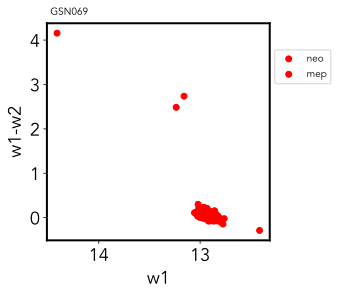

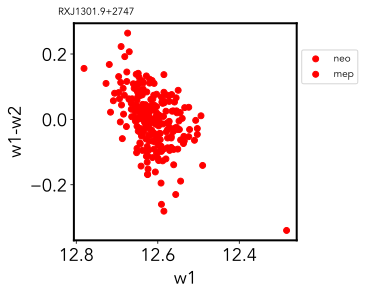

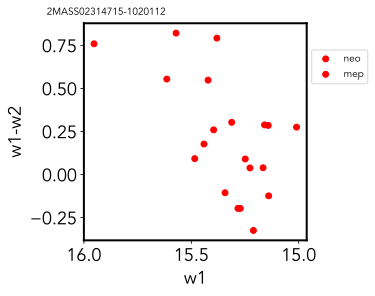

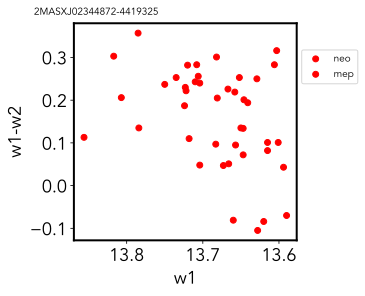

In [108]:
plotlist=qpe_name_list

for index_test in range(len(qpe_name_list)):
    name_test=plotlist[index_test]
    #print(name_test)
    search_name=name_test
    #search_name=name_test.replace(' ','') 
    save_name=search_name

    data_test_neo=pd.read_csv('../QPE/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13] 
    #data_test_neo=data_test_neo[data_test_neo['w1snr']>10]
    #data_test_neo=data_test_neo[data_test_neo['w2snr']>10]
    
    #data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>0]
    
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('../QPE/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    
    fig = plt.figure(figsize=(4,4))
    fig.subplots_adjust(hspace=0.0, wspace = 0.0)
    ax = fig.add_subplot(111)

    ax.scatter(data_test_neo['w1mpro'],data_test_neo['w1mpro']-data_test_neo['w2mpro'],color='red',label='neo')
    ax.scatter(data_test_mep['w1mpro_ep'],data_test_mep['w1mpro_ep']-data_test_mep['w2mpro_ep'],color='red',label='mep')

    
    #ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
    #ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
          loc=2,fontsize=10)
    
    #bottom, top = plt.ylim() 
    #plt.ylim(top,bottom)
    
    bottom, top = plt.xlim() 
    plt.xlim(top,bottom)
    
    plt.xlabel('w1')
    plt.ylabel(r'w1-w2')
    
    ax.text(0.1, 1.05,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
    plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/QPElc/WISE_w1_w1-w2_%s.png'%save_name, 
            dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    